# Modelling exercise

This is the third part of the Data Science hiring assessment. The assessment further develops the business question from the first interview. 

The goal is to forecast demand for a given product(SKU)-Supermarket combination

### Load basic packages


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_demand, read_promotions
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

### Import Data


In [2]:
# Demand data
demand = read_demand("./demand.csv")
demand.head(2)

demand         sku   supermarket
date                                        
2019-01-01    93.0  desperados  albert-heijn
2019-01-02    93.0  desperados  albert-heijn

In [3]:
# promotion data
promotions = read_promotions( "./promotions.csv")
promotions.head(2)

sku supermarket
promotion_date                        
2020-09-26      desperados       jumbo
2019-09-18      desperados       jumbo

# Prepare the data for modelling

Cleans the demand, merges with the promotion data, and aggregates to weekly data

<b> Note: </b> At this point I decided not to aggregate the data on a weekly basis, but to first deal with the outliers and then aggregate data on a weekly basis.

In [4]:
from utils import merge, clean_demand_per_group, aggregate_to_weekly, extend_promotions_days

def prepare_data(demand, promotions):
    cleaned_demand = clean_demand_per_group(demand)
    extended_promotions = extend_promotions_days(promotions, 7)
    daily = merge(cleaned_demand, extended_promotions)
    # weekly = aggregate_to_weekly(daily)
    return daily

df = prepare_data(demand, promotions)
df.head(10)

demand         sku   supermarket  promotion_id  promotion
date                                                                 
2019-01-01    93.0  desperados  albert-heijn           NaN      False
2019-01-02    93.0  desperados  albert-heijn           NaN      False
2019-01-03    94.0  desperados  albert-heijn           NaN      False
2019-01-04    95.0  desperados  albert-heijn           NaN      False
2019-01-05    92.0  desperados  albert-heijn           NaN      False
2019-01-06    87.0  desperados  albert-heijn           NaN      False
2019-01-07    90.0  desperados  albert-heijn           NaN      False
2019-01-08    90.0  desperados  albert-heijn           NaN      False
2019-01-09    92.0  desperados  albert-heijn           NaN      False
2019-01-10    93.0  desperados  albert-heijn           NaN      False

## Steps to take

General guideline to tackle the exercise, this is just for your reference, add/subtract as you think would be best for the problem

- Feature engineering and data preparation for modelling
    - Prepare the data for modelling and create new features if possible. 
- Create a model
    - The business wants to predict the demand for each SKU per supermarket eight weeks in advance. 
    - You are free to choose any kind of model that you like and think would fit best for the exercise. No need to focus on optimizing the error metric with an advanced model
    - Your model should be able to predict the demand for each SKU and supermarket eight weeks in advance
    - What is the impact of different features/variables on the demand?    
- Evaluation
    - Feel free again to choose any metric that you think fits best to the given problem
    - We would like to understand why you have chosen a particular metric and the process of validation and evaluation of the model. It would also be good if you can tie this up with how the business would evaluate the solution and what kind of impact it can have on the existing process    
    

## Data Preparation

In [5]:
# Replace outliers with interpolation

def identify_outliers(df):
    outliers_dict = {}

    for (sku, supermarket), group in df.groupby(['sku', 'supermarket']):
        # Calculate IQR (Interquartile Range)
        Q1 = group['demand'].quantile(0.25)
        Q3 = group['demand'].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        outliers = group[(group['demand'] < lower_bound) | (group['demand'] > upper_bound)]
        outliers_dict[(sku, supermarket)] = outliers.index.tolist()

    return outliers_dict
    
def replace_outliers_with_interpolation(df):
    # Find outliers
    outliers_dict = identify_outliers(df)

    # Replace outliers with interpolaction
    for indices in outliers_dict.values():
        df.loc[indices, 'demand'] = np.nan

    df['demand'] = df['demand'].interpolate(method='linear')  # Linear interpolaton

    return df

df_interp = df.copy()
df_interp = replace_outliers_with_interpolation(df_interp)

In [6]:
# Aggregete data weekly
grouped = df_interp.groupby(["sku", "supermarket"])
# Performs a simplistic aggregation of promotion. 
# If a promotion occured during the week this variable will return the number of days the promotion occurs.
df_weekly = grouped.apply(lambda df: df.resample("W").agg({"demand": "sum", "promotion": "sum"}))
df_weekly = df_weekly.reset_index().set_index("date")

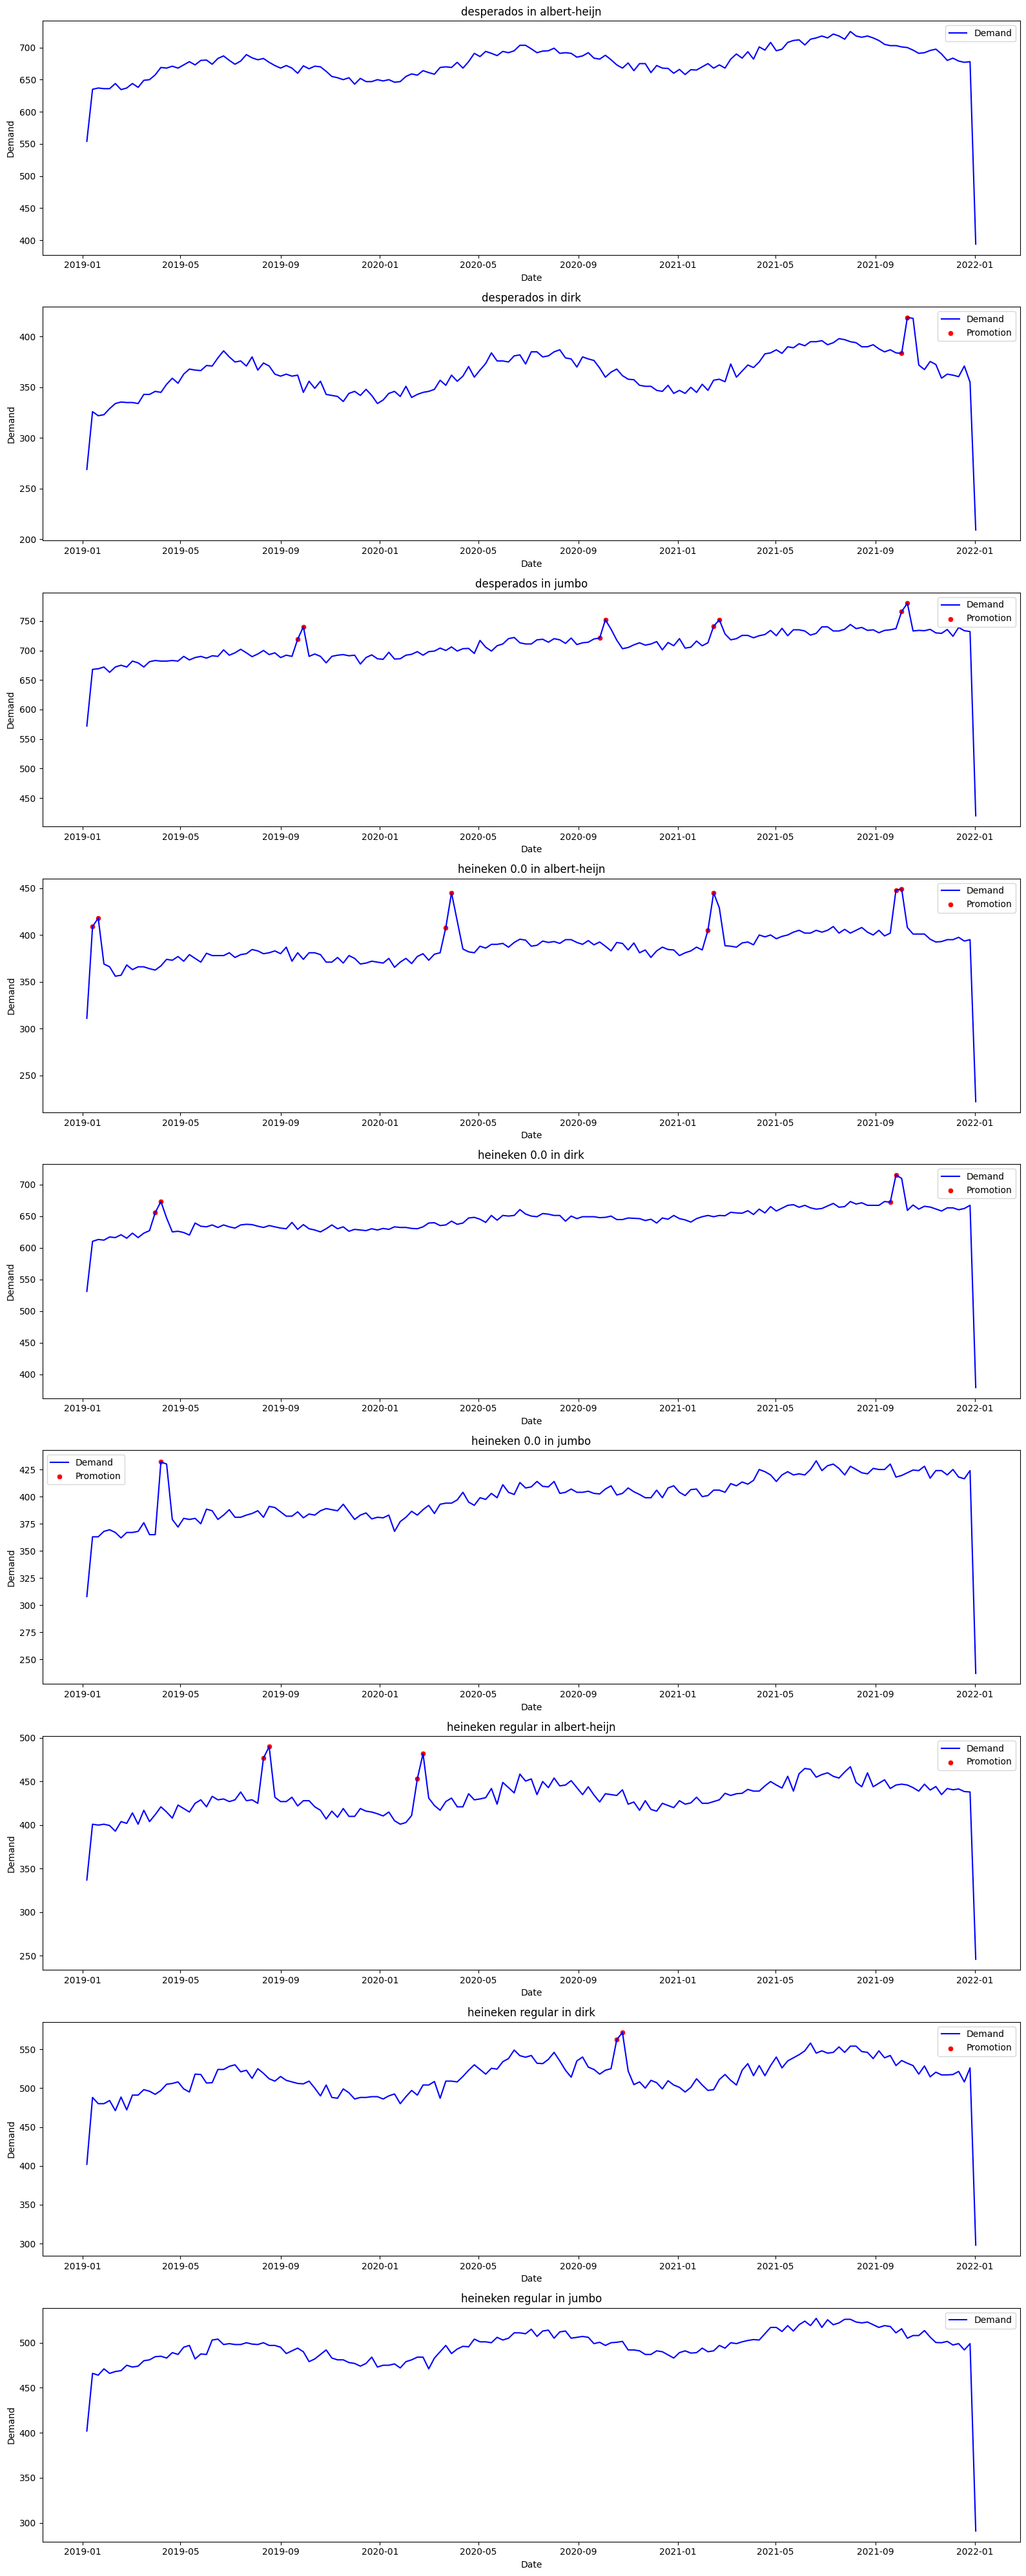

In [7]:
# Plot the result of the aggregation and outliers replacement 
def plot_demand_with_promotion(group, sku, supermarket, ax):
    group = group.reset_index()

    # Draw the entire line in blue (without distinction on the page)
    sns.lineplot(
        x='date', 
        y='demand', 
        data=group, 
        color='blue', 
        label='Demand', 
        ax=ax
    )
    
    # Highlight in red the points where `promotion == True`
    sns.scatterplot(
        x='date', 
        y='demand', 
        data=group[group['promotion'] != 0], 
        color='red', 
        label='Promotion', 
        ax=ax
    )


    ax.set_title(f'{sku} in {supermarket}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Demand')

grouped = df_weekly.groupby(['sku', 'supermarket'])

fig, axes = plt.subplots(9, 1, figsize=(16, 40))
axes = axes.flatten()

for ax, ((sku, supermarket), group) in zip(axes, grouped):
    plot_demand_with_promotion(group, sku, supermarket, ax)

plt.tight_layout()
plt.show()

Looking at the daily data from the data analysis notebook, it was possible to observe the trend and seasonality more. It is also visible from these charts, but in order not to lose daily information, it would be worth introducing a new feature at the daily level, e.g. maximum change in daily demand in the week.

Additionally, the boundary values are underestimated because they do not contain a full week. A good approach would be to multiply each of these values by a scalar that will give us a full week (e.g. if the first week contains 3 days, we multiply the demand value by 7/3). But for the purposes of this exercise, I will simplify the approach and just remove the extreme weeks.

In [8]:
# Delete rows with minimum and maximum index
def remove_min_max_index(group):
    min_index = group.index.min()
    max_index = group.index.max()
    return group.drop([min_index, max_index])

df_weekly = df_weekly.groupby(['sku', 'supermarket'], group_keys=False).apply(remove_min_max_index)

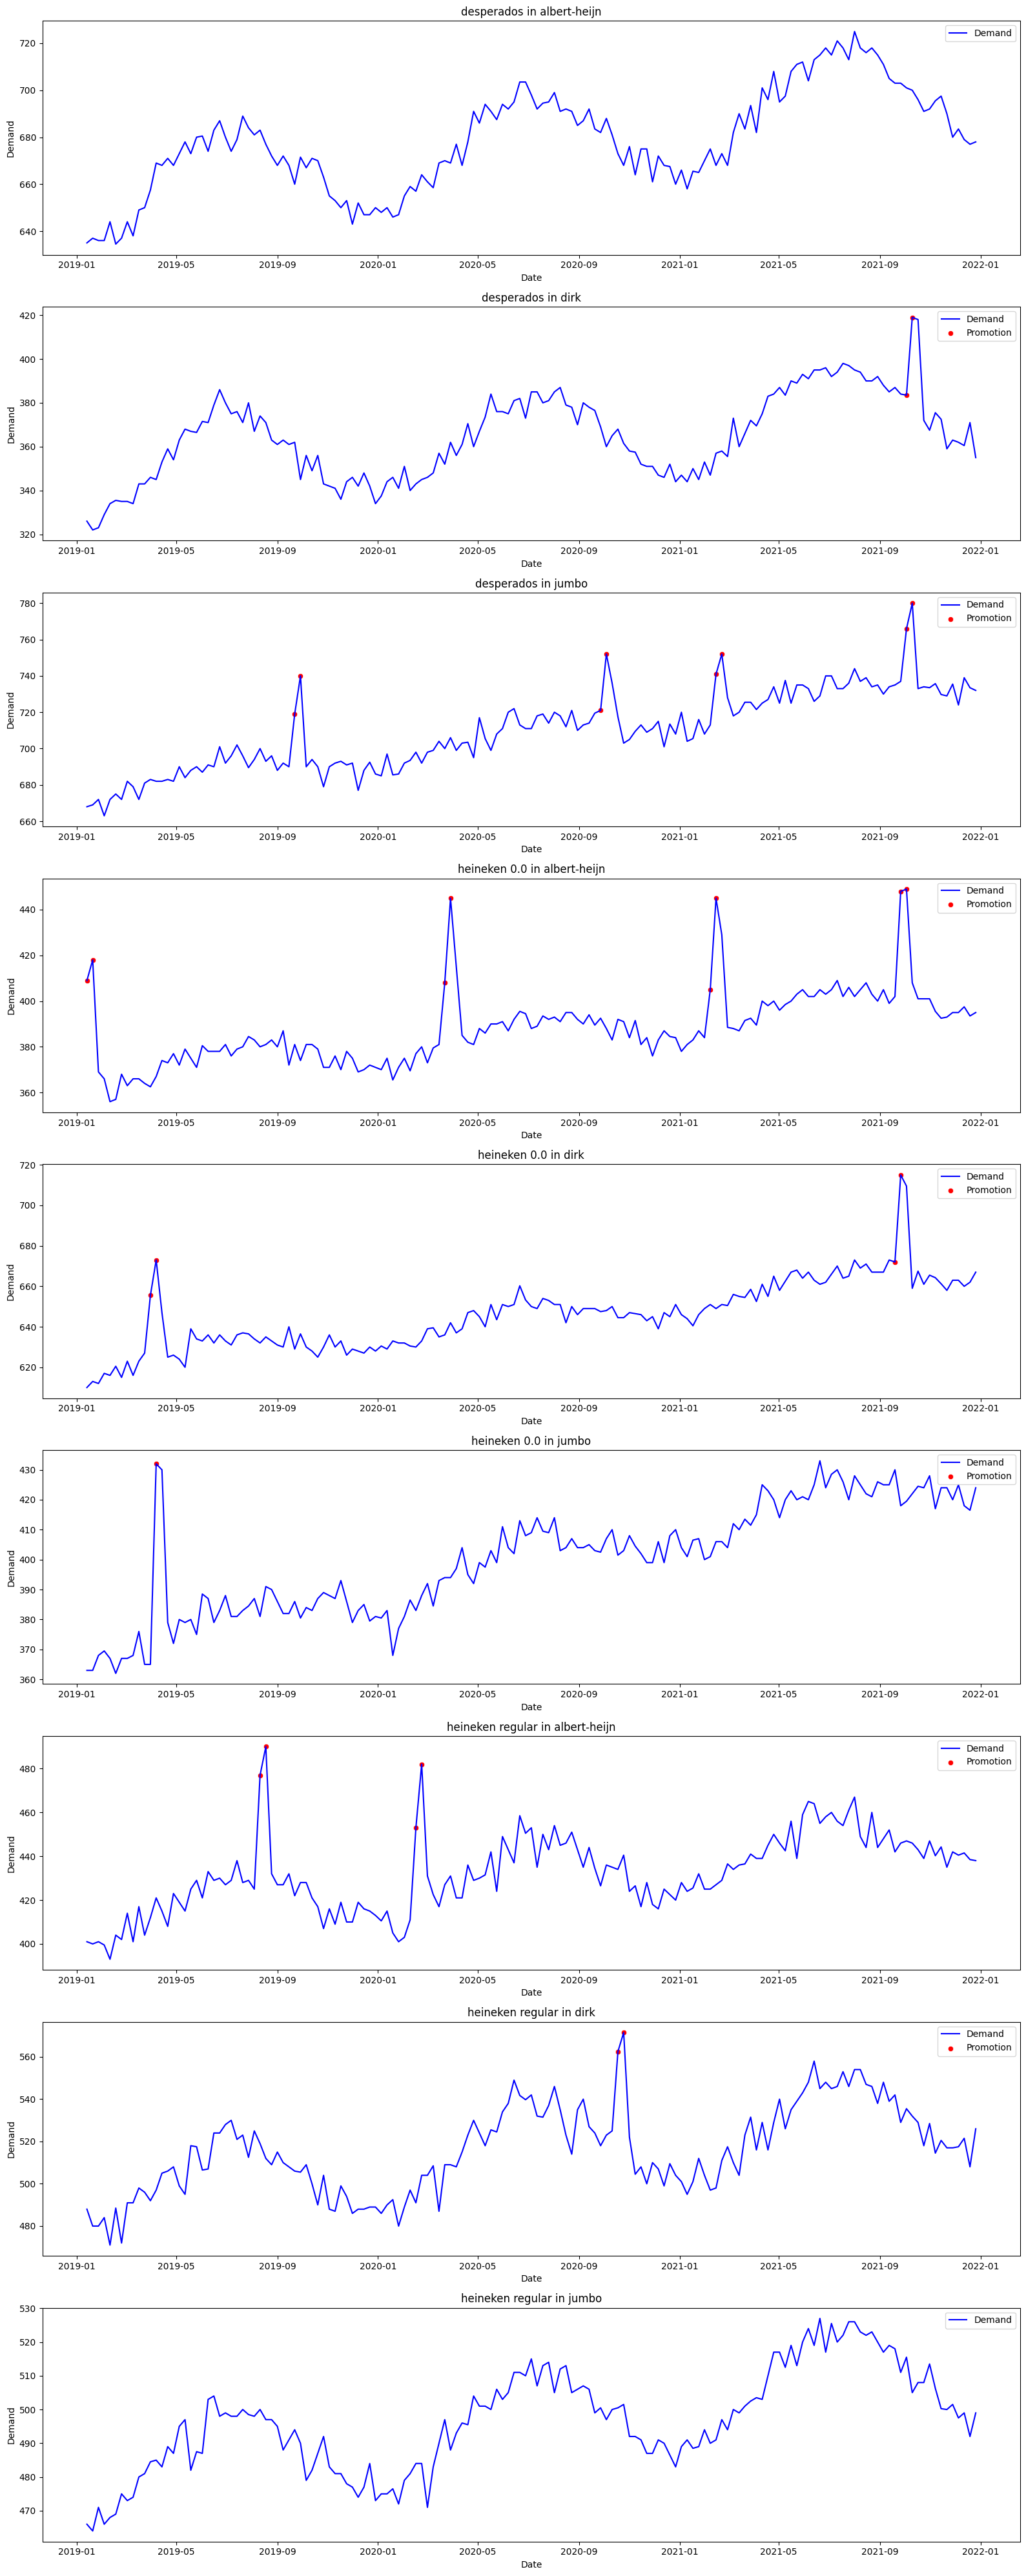

In [9]:
# Plot the result of the aggregation and outliers replacement 
def plot_demand_with_promotion(group, sku, supermarket, ax):
    group = group.reset_index()

    # Draw the entire line in blue (without distinction on the page)
    sns.lineplot(
        x='date', 
        y='demand', 
        data=group, 
        color='blue', 
        label='Demand', 
        ax=ax
    )
    
    # Highlight in red the points where `promotion == True`
    sns.scatterplot(
        x='date', 
        y='demand', 
        data=group[group['promotion'] != 0], 
        color='red', 
        label='Promotion', 
        ax=ax
    )


    ax.set_title(f'{sku} in {supermarket}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Demand')

grouped = df_weekly.groupby(['sku', 'supermarket'])

fig, axes = plt.subplots(9, 1, figsize=(16, 40))
axes = axes.flatten()

for ax, ((sku, supermarket), group) in zip(axes, grouped):
    plot_demand_with_promotion(group, sku, supermarket, ax)

plt.tight_layout()
plt.show()

In [10]:
# Add new date features
df_weekly['year'] = df_weekly.index.year
df_weekly['month'] = df_weekly.index.month
df_weekly['week_of_year'] = df_weekly.index.isocalendar().week

In [19]:
# Add lag features
def prepare_forecast_data(group, weeks_ahead=8):
    
    group['lag_1'] = group['demand'].shift(1) 
    group['lag_2'] = group['demand'].shift(2)
    group['lag_4'] = group['demand'].shift(4)
    group['lag_8'] = group['demand'].shift(8)
    group['promotion_target'] = group['promotion'].shift(-weeks_ahead)

    # Fill in NaN in lags with demand value
    group.fillna(method='bfill', inplace=True)

    group['target_demand'] = group['demand'].shift(-weeks_ahead)
    group.rename(columns={'demand': 'this_week_demand',
                         'promotion': 'this_week_promotion'}, inplace=True)
    group.dropna(subset=['target_demand'], inplace=True)

    

    
    return group
results = []

for (sku, supermarket), group in df_weekly.groupby(['sku', 'supermarket']):
    group_with_lags = prepare_forecast_data(group.copy())
    results.append(group_with_lags)

df_target = pd.concat(results)

### Train Test Split

In [20]:
unique_index_list = df_target.index.unique().sort_values()
cutoff_index = np.ceil(len(unique_index_list) * 0.8)
cuttof_date = unique_index_list[int(cutoff_index)]

In [21]:
df_target

sku   supermarket  this_week_demand  \
date                                                           
2019-01-13        desperados  albert-heijn             635.0   
2019-01-20        desperados  albert-heijn             637.0   
2019-01-27        desperados  albert-heijn             636.0   
2019-02-03        desperados  albert-heijn             636.0   
2019-02-10        desperados  albert-heijn             644.0   
...                      ...           ...               ...   
2021-10-03  heineken regular         jumbo             515.5   
2021-10-10  heineken regular         jumbo             505.0   
2021-10-17  heineken regular         jumbo             508.0   
2021-10-24  heineken regular         jumbo             508.0   
2021-10-31  heineken regular         jumbo             513.5   

            this_week_promotion  year  month  week_of_year  lag_1  lag_2  \
date                                                                       
2019-01-13                    0  2019      1             2  635.0  635.0   
2019-01-20                    0  2019      1             3  635.0  635.0   
2019-01-27                    0  2019      1             4  637.0  635.0   
2019-02-03                    0  2019      2             5  636.0  637.0   
2019-02-10                    0  2019      2             6  636.0  636.0   
...                         ...   ...    ...           ...    ...    ...   
2021-10-03                    0  2021     10            39  511.0  518.0   
2021-10-10                    0  2021     10            40  515.5  511.0   
2021-10-17                    0  2021     10            41  505.0  515.5   
2021-10-24                    0  2021     10            42  508.0  505.0   
2021-10-31                    0  2021     10            43  508.0  508.0   

            lag_4  lag_8  promotion_target  target_demand  
date                                                       
2019-01-13  635.0  635.0               0.0          638.0  
2019-01-20  635.0  635.0               0.0          649.0  
2019-01-27  635.0  635.0               0.0          650.0  
2019-02-03  635.0  635.0               0.0          657.5  
2019-02-10  635.0  635.0               0.0          669.0  
...           ...    ...               ...            ...  
2021-10-03  517.0  523.0               0.0          501.5  
2021-10-10  519.0  522.0               0.0          497.5  
2021-10-17  518.0  523.0               0.0          499.0  
2021-10-24  511.0  520.0               0.0          492.0  
2021-10-31  515.5  517.0               0.0          499.0  

[1323 rows x 13 columns]

In [24]:
# Use One-Hot Encoding for 'sku' and 'supermarket' columns
df_target = pd.get_dummies(df_target, columns=['sku', 'supermarket'])

In [25]:
train_data = df_target[df_target.index <= cuttof_date]
test_data = df_target[df_target.index > cuttof_date]

X_train = train_data.drop(columns=['target_demand'])
y_train = train_data['target_demand']

X_test = test_data.drop(columns=['target_demand'])
y_test = test_data['target_demand']

In [26]:
X_train

this_week_demand  this_week_promotion  year  month  week_of_year  \
date                                                                           
2019-01-13             635.0                    0  2019      1             2   
2019-01-20             637.0                    0  2019      1             3   
2019-01-27             636.0                    0  2019      1             4   
2019-02-03             636.0                    0  2019      2             5   
2019-02-10             644.0                    0  2019      2             6   
...                      ...                  ...   ...    ...           ...   
2021-03-21             501.0                    0  2021      3            11   
2021-03-28             502.5                    0  2021      3            12   
2021-04-04             503.5                    0  2021      4            13   
2021-04-11             503.0                    0  2021      4            14   
2021-04-18             510.0                    0  2021      4            15   

            lag_1  lag_2  lag_4  lag_8  promotion_target  sku_desperados  \
date                                                                       
2019-01-13  635.0  635.0  635.0  635.0               0.0            True   
2019-01-20  635.0  635.0  635.0  635.0               0.0            True   
2019-01-27  637.0  635.0  635.0  635.0               0.0            True   
2019-02-03  636.0  637.0  635.0  635.0               0.0            True   
2019-02-10  636.0  636.0  635.0  635.0               0.0            True   
...           ...    ...    ...    ...               ...             ...   
2021-03-21  499.0  500.0  497.0  489.0               0.0           False   
2021-03-28  501.0  499.0  494.0  494.0               0.0           False   
2021-04-04  502.5  501.0  500.0  490.0               0.0           False   
2021-04-11  503.5  502.5  499.0  491.0               0.0           False   
2021-04-18  503.0  503.5  501.0  497.0               0.0           False   

            sku_heineken 0.0  sku_heineken regular  supermarket_albert-heijn  \
date                                                                           
2019-01-13             False                 False                      True   
2019-01-20             False                 False                      True   
2019-01-27             False                 False                      True   
2019-02-03             False                 False                      True   
2019-02-10             False                 False                      True   
...                      ...                   ...                       ...   
2021-03-21             False                  True                     False   
2021-03-28             False                  True                     False   
2021-04-04             False                  True                     False   
2021-04-11             False                  True                     False   
2021-04-18             False                  True                     False   

            supermarket_dirk  supermarket_jumbo  
date                                             
2019-01-13             False              False  
2019-01-20             False              False  
2019-01-27             False              False  
2019-02-03             False              False  
2019-02-10             False              False  
...                      ...                ...  
2021-03-21             False               True  
2021-03-28             False               True  
2021-04-04             False               True  
2021-04-11             False               True  
2021-04-18             False               True  

[1071 rows x 16 columns]

In [27]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [28]:
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [29]:
tscv = TimeSeriesSplit(n_splits=5)

# Validation
for train_index, val_index in tscv.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    grid_search.fit(X_train_cv, y_train_cv)
    
    y_val_pred = grid_search.predict(X_val_cv)
    
    mse = mean_squared_error(y_val_cv, y_val_pred)
    print(f"Mean Squared Error: {mse}")

Mean Squared Error: 727.7877659604236
Mean Squared Error: 13658.671982348138
Mean Squared Error: 166.19043781929597
Mean Squared Error: 2716.0464226363038
Mean Squared Error: 162.20244831260126


In [ ]:
test_data

Test Mean Squared Error: 198.7354888022907


C:\Users\Rafał Hernik\AppData\Local\Temp\ipykernel_18048\1934646121.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_demand'] = best_model.predict(X)


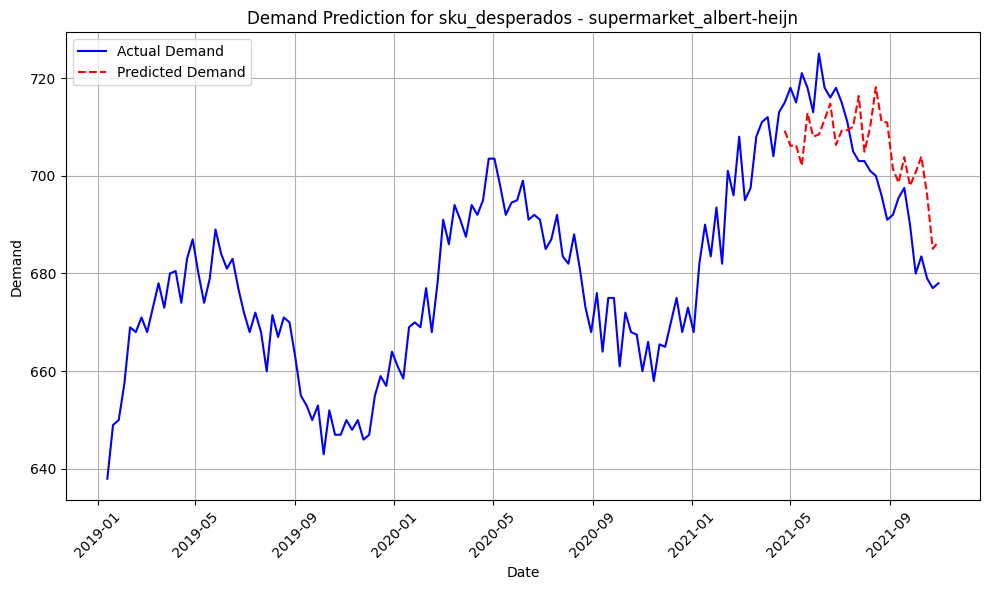

C:\Users\Rafał Hernik\AppData\Local\Temp\ipykernel_18048\1934646121.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_demand'] = best_model.predict(X)


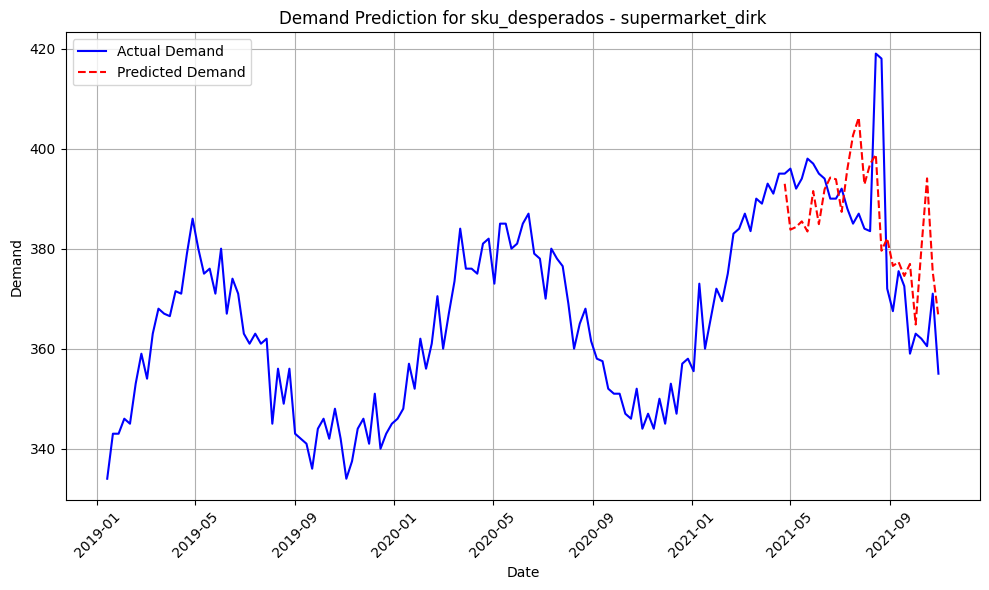

C:\Users\Rafał Hernik\AppData\Local\Temp\ipykernel_18048\1934646121.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_demand'] = best_model.predict(X)


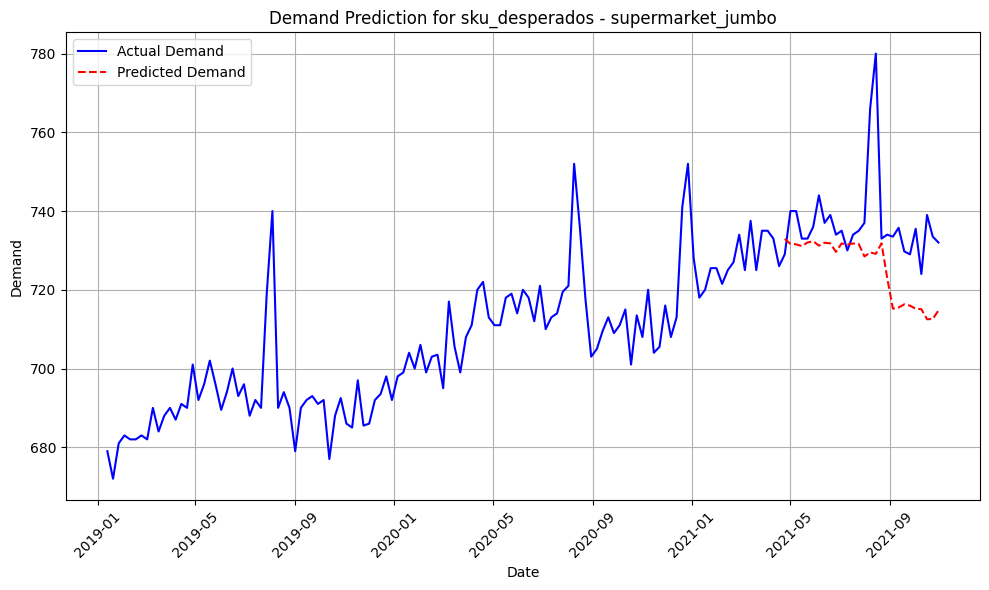

C:\Users\Rafał Hernik\AppData\Local\Temp\ipykernel_18048\1934646121.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_demand'] = best_model.predict(X)


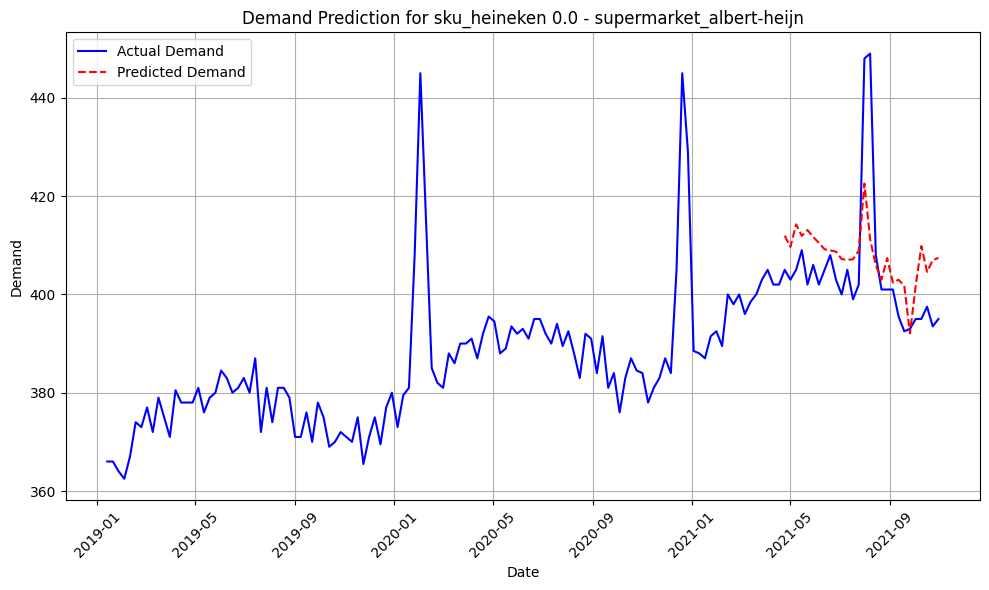

C:\Users\Rafał Hernik\AppData\Local\Temp\ipykernel_18048\1934646121.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_demand'] = best_model.predict(X)


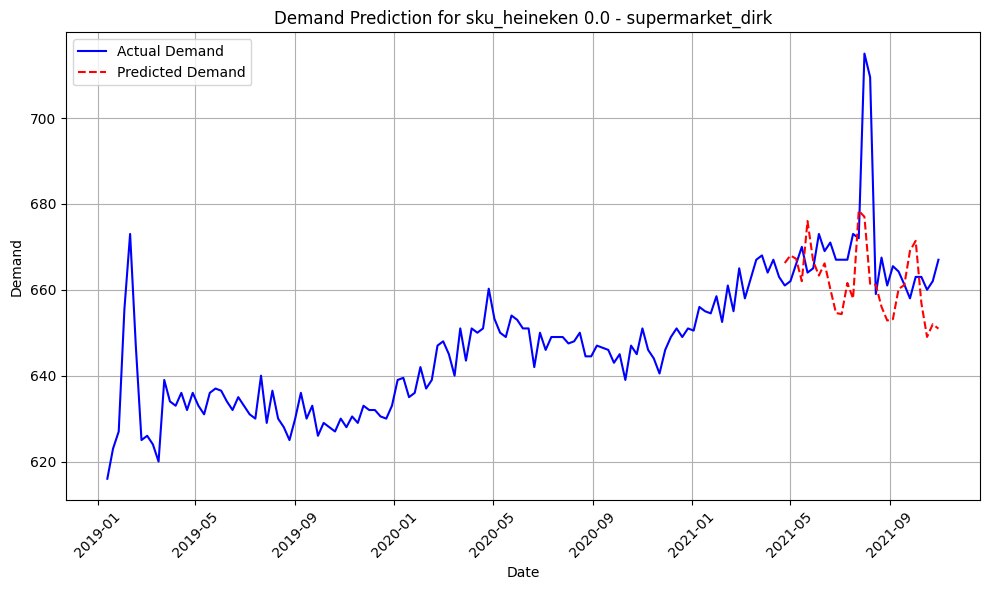

C:\Users\Rafał Hernik\AppData\Local\Temp\ipykernel_18048\1934646121.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_demand'] = best_model.predict(X)


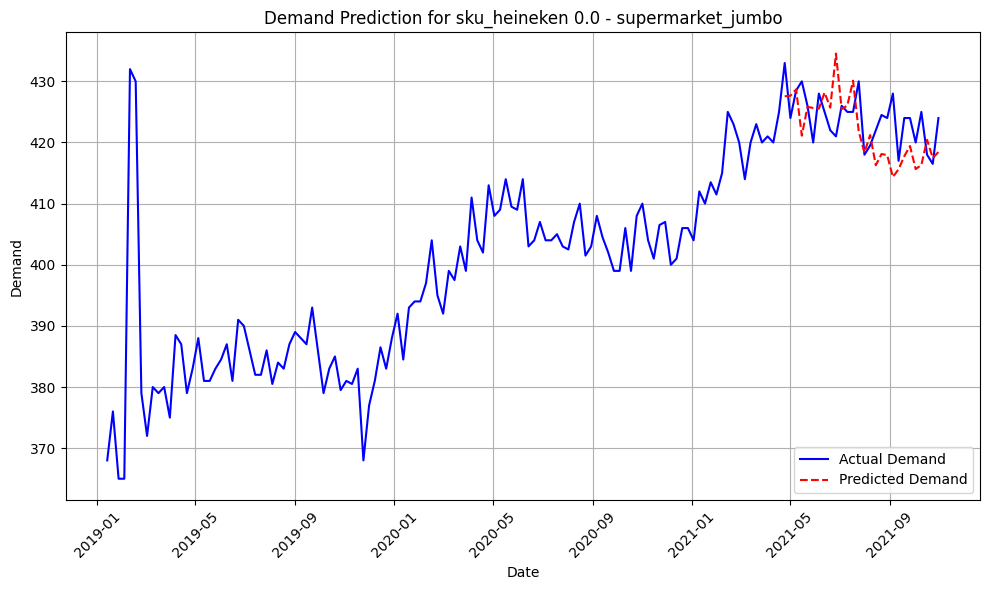

C:\Users\Rafał Hernik\AppData\Local\Temp\ipykernel_18048\1934646121.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_demand'] = best_model.predict(X)


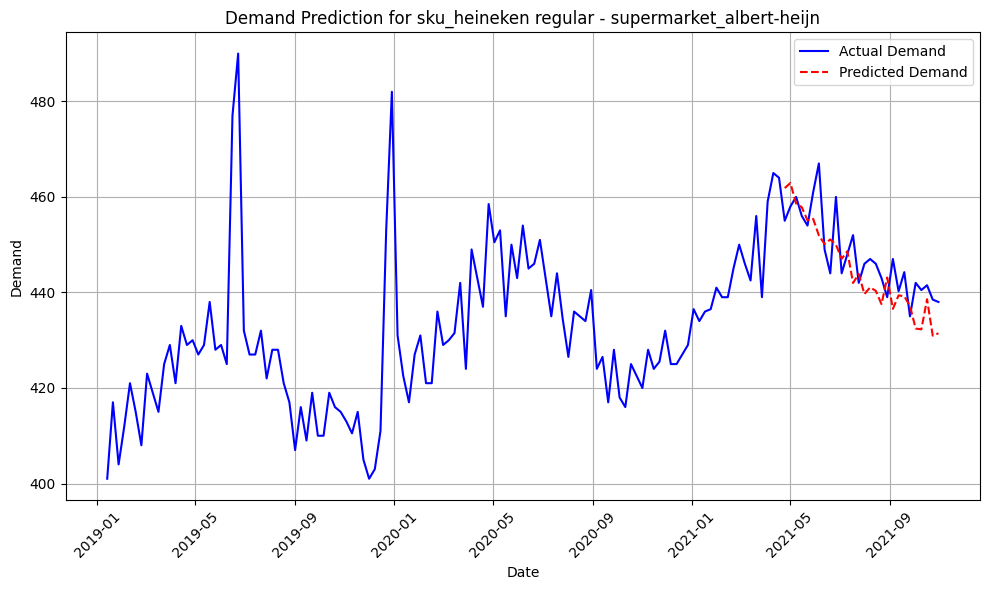

C:\Users\Rafał Hernik\AppData\Local\Temp\ipykernel_18048\1934646121.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_demand'] = best_model.predict(X)


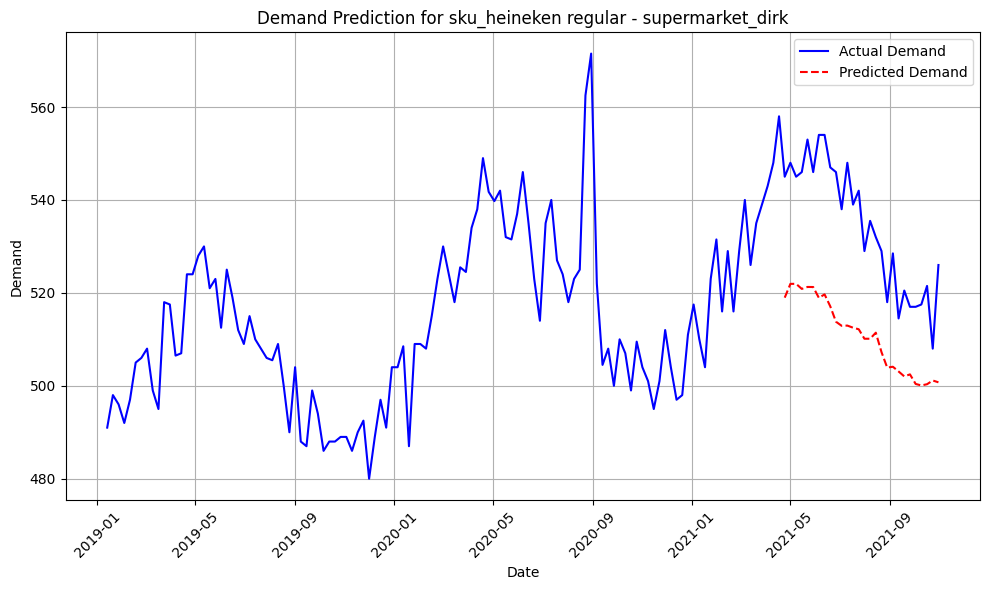

C:\Users\Rafał Hernik\AppData\Local\Temp\ipykernel_18048\1934646121.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_demand'] = best_model.predict(X)


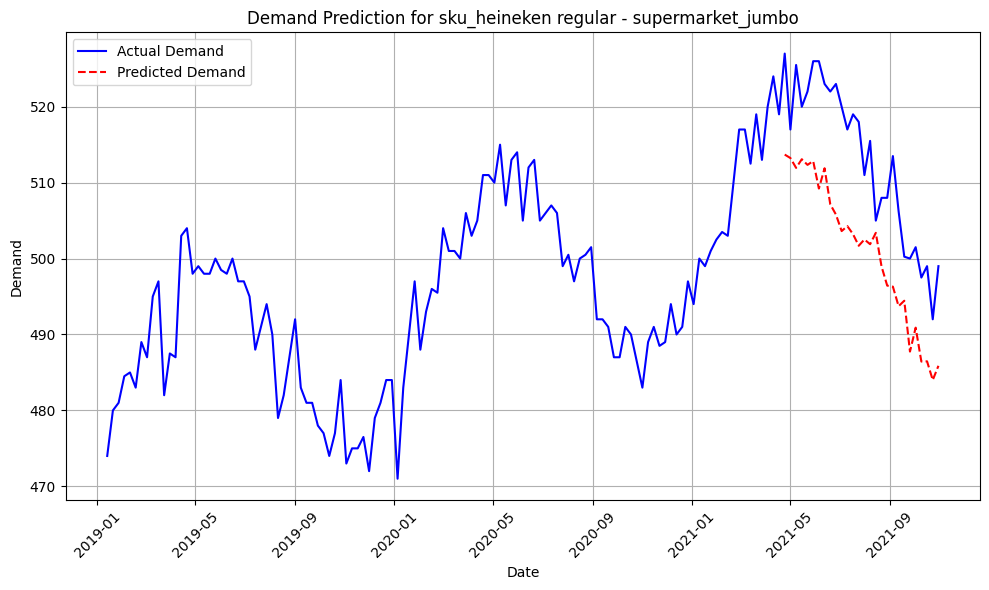

In [38]:
# Predykcja na zbiorze testowym
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)

# Ocena
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test Mean Squared Error: {test_mse}")

# Lista kolumn SKU i supermarketów
sku_columns = ['sku_desperados', 'sku_heineken 0.0', 'sku_heineken regular']
supermarket_columns = ['supermarket_albert-heijn', 'supermarket_dirk', 'supermarket_jumbo']

# Lista cech do modelowania (bez targetu)
features = ['this_week_demand', 'this_week_promotion', 'year', 'month', 
            'week_of_year', 'lag_1', 'lag_2', 'lag_4', 'lag_8', 'promotion_target'] + sku_columns + supermarket_columns

# Funkcja do rysowania wykresów dla każdej grupy
def plot_group(test_data, df, group_name):
    plt.figure(figsize=(10, 6))
    
    # Rysowanie rzeczywistego zapotrzebowania
    plt.plot(df.index, df['target_demand'], label='Actual Demand', color='blue')

    # Rysowanie prognozowanego zapotrzebowania
    plt.plot(test_data.index, test_data['predicted_demand'], label='Predicted Demand', color='red', linestyle='--')


    # Ustawienia osi i tytułu
    plt.title(f'Demand Prediction for {group_name}')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Funkcja do trenowania modelu i predykcji dla każdej grupy
def train_and_predict_group(df, group_name):
    # Przygotowanie X i y
    test_data = df[df.index > cuttof_date]
    X = test_data[features]
    y = test_data['target_demand']
    
    # Model XGBoost
    best_model.predict(X)

    # Predykcje
    test_data['predicted_demand'] = best_model.predict(X)

    # Rysowanie wykresu
    plot_group(test_data, df, group_name)

# Przechodzenie przez każdą kombinację SKU i supermarketów
for sku_col in sku_columns:
    for supermarket_col in supermarket_columns:
        # Filtracja danych dla tej grupy
        group_data = df_target[(df_target[sku_col] == True) & (df_target[supermarket_col] == True)]
                
        if not group_data.empty:
            group_name = f"{sku_col} - {supermarket_col}"
            train_and_predict_group(group_data, group_name)
